In [1]:
# @title 3. Dowbload library
import os

!apt-get update -qq > /dev/null
!apt-get install openjdk-17-jdk-headless -qq > /dev/null

!pip install -q pyspark findspark
# !pip install -q synapseml

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [2]:
print("Memeriksa versi Java...")
!java -version

Memeriksa versi Java...
openjdk version "17.0.17" 2025-10-21
OpenJDK Runtime Environment (build 17.0.17+10-Ubuntu-122.04)
OpenJDK 64-Bit Server VM (build 17.0.17+10-Ubuntu-122.04, mixed mode, sharing)


In [3]:
# @title 2. Set up
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("SentimentAnalysisBigData") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

print(f"\nSukses! Spark Version: {spark.version}")


Sukses! Spark Version: 4.0.1


In [4]:
# @title 3. Upload Dataset
from google.colab import files

uploaded = files.upload()

filename = list(uploaded.keys())[0]
print(f"File {filename} berhasil diupload.")

Saving reviews_mcd.csv to reviews_mcd.csv
File reviews_mcd.csv berhasil diupload.


In [5]:
# @title 4. Load Data ke Spark DataFrame

df_spark = spark.read.option("header", "true") \
    .option("quote", "\"") \
    .option("escape", "\"") \
    .option("multiLine", "true") \
    .option("inferSchema", "true") \
    .csv(filename)

print("Preview Data Awal:")
df_spark.show(5, truncate=False)

df_spark.printSchema()

Preview Data Awal:
+-----------+--------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|nama_tempat|user                |review                                                                                                                                                                                                                                                                                                                 |rating|
+-----------+--------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [6]:
# @title 5. Data Cleaning & Labeling
from pyspark.sql.functions import col, lower, regexp_replace, when, trim

def clean_text_spark(df):
    # 1. Lowercase
    df = df.withColumn("clean_review", lower(col("review")))

    # 2. Hapus URL (http/https/www)
    df = df.withColumn("clean_review", regexp_replace(col("clean_review"), r'https?://\S+|www\.\S+', ''))

    # 3. Hapus karakter non-alfabet (angka & simbol)
    df = df.withColumn("clean_review", regexp_replace(col("clean_review"), r'[^a-z\s]', ' '))

    # 4. Hapus spasi berlebih
    df = df.withColumn("clean_review", trim(regexp_replace(col("clean_review"), r'\s+', ' ')))

    # 5. Filter baris kosong
    df = df.filter((col("clean_review").isNotNull()) & (col("clean_review") != ""))

    return df

df_clean = clean_text_spark(df_spark)

df_clean = df_clean.withColumn("label",
    when(col("rating").isin(1, 2), 0.0)  # Negative
    .when(col("rating") == 3, 1.0)       # Neutral
    .otherwise(2.0)                      # Positive
)

print("Data setelah cleaning dan labeling:")
df_clean.select("rating", "label", "clean_review").show(5, truncate=False)

Data setelah cleaning dan labeling:
+------+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|rating|label|clean_review                                                                                                                                                                                                                                                                                                       |
+------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [7]:
# @title 6. Menghitung Class Weights
import numpy as np

class_counts = df_clean.groupBy("label").count().collect()
total_count = df_clean.count()
num_classes = len(class_counts)

class_weights = {}
print("Distribusi Data & Bobot:")
for row in class_counts:
    label = row['label']
    count = row['count']

    weight = total_count / (num_classes * count)
    class_weights[label] = weight
    print(f"Class {label}: {count} data | Weight: {weight:.4f}")

from itertools import chain
from pyspark.sql.functions import create_map, lit

mapping_expr = create_map([lit(x) for x in chain(*class_weights.items())])
df_weighted = df_clean.withColumn("classWeight", mapping_expr.getItem(col("label")))

df_weighted.select("label", "classWeight").show(5)

Distribusi Data & Bobot:
Class 0.0: 345 data | Weight: 4.9845
Class 1.0: 394 data | Weight: 4.3646
Class 2.0: 4420 data | Weight: 0.3891


/usr/local/lib/python3.12/dist-packages/pyspark/sql/classic/column.py:359: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


+-----+-------------------+
|label|        classWeight|
+-----+-------------------+
|  2.0|0.38906485671191554|
|  2.0|0.38906485671191554|
|  0.0|  4.984541062801933|
|  2.0|0.38906485671191554|
|  0.0|  4.984541062801933|
+-----+-------------------+
only showing top 5 rows


In [8]:
# @title 7. Membangun Pipeline NLP
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression

tokenizer = Tokenizer(inputCol="clean_review", outputCol="words")

remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features")

lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    weightCol="classWeight",
    maxIter=20,
    family="multinomial" # Karena ada 3 kelas (Pos, Neg, Net)
)

# Gabungkan dalam Pipeline
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, lr])
print("Pipeline berhasil dibangun.")

Pipeline berhasil dibangun.


In [9]:
# @title 8. Split Data & Training Model
train_data, test_data = df_weighted.randomSplit([0.8, 0.2], seed=42)

print(f"Jumlah Training Data: {train_data.count()}")
print(f"Jumlah Testing Data: {test_data.count()}")

print("Sedang melatih model... (Tunggu sebentar)")
model = pipeline.fit(train_data)
print("Training selesai!")

predictions = model.transform(test_data)
predictions.select("clean_review", "label", "prediction", "probability").show(5)

Jumlah Training Data: 4162
Jumlah Testing Data: 997
Sedang melatih model... (Tunggu sebentar)
Training selesai!
+--------------------+-----+----------+--------------------+
|        clean_review|label|prediction|         probability|
+--------------------+-----+----------+--------------------+
|mcd enak cepet ga...|  2.0|       2.0|[2.98912002691687...|
|meskipun ramai pe...|  2.0|       2.0|[2.61378763156331...|
|tempatnya nyaman ...|  2.0|       2.0|[6.04812501154804...|
|sangat eropa bang...|  2.0|       2.0|[7.06422001844314...|
|tempatnya bagus p...|  2.0|       2.0|[9.15789009206642...|
+--------------------+-----+----------+--------------------+
only showing top 5 rows


------------------------------
Accuracy  : 0.7904
F1 Score  : 0.8085
Precision : 0.8330
Recall    : 0.7904
------------------------------


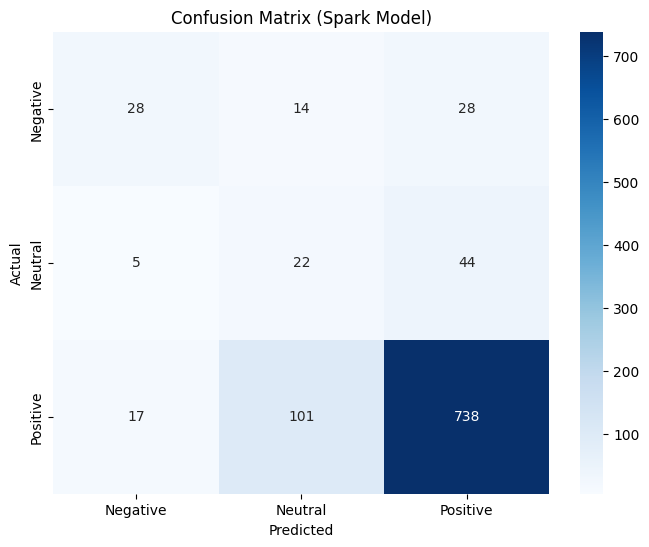

In [10]:
# @title 9. Evaluasi Performa Model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

acc = evaluator_acc.evaluate(predictions)
f1 = evaluator_f1.evaluate(predictions)
prec = evaluator_precision.evaluate(predictions)
rec = evaluator_recall.evaluate(predictions)

print("-" * 30)
print(f"Accuracy  : {acc:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print("-" * 30)

y_true = predictions.select("label").toPandas()
y_pred = predictions.select("prediction").toPandas()

cm = confusion_matrix(y_true, y_pred)
labels = ['Negative', 'Neutral', 'Positive']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Spark Model)')
plt.show()

In [12]:
# @title 10. Modeling: GBT (Gradient Boosted Trees) dengan Pipeline
from pyspark.ml.classification import GBTClassifier, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# 2. Model Stage
# Kita gunakan GBT sebagai base classifier
gbt = GBTClassifier(
    maxIter=10,
    maxDepth=5,
    featuresCol="features",
    labelCol="label",
    seed=42
)

# Bungkus dengan OneVsRest karena kita memiliki 3 kelas
ovr_gbt = OneVsRest(
    classifier=gbt,
    featuresCol="features",
    labelCol="label"
)

# 3. Membangun Pipeline Lengkap
# Pipeline akan memastikan urutan: Clean Text -> Words -> Features -> Model
pipeline_gbt = Pipeline(stages=[tokenizer, remover, hashingTF, idf, ovr_gbt])

# 4. Training
print("Sedang melatih GBT melalui Pipeline... (Mohon tunggu)")
# Gunakan 'train_data' yang berisi kolom 'clean_review' dan 'label'
model_gbt = pipeline_gbt.fit(train_data)

# 5. Prediksi & Evaluasi
predictions_gbt = model_gbt.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
acc_gbt = evaluator.evaluate(predictions_gbt)

print("-" * 30)
print(f"✅ GBT Accuracy: {acc_gbt:.4f}")
print("-" * 30)

# Tampilkan Hasil
predictions_gbt.select("clean_review", "label", "prediction").show(5, truncate=80)

Sedang melatih GBT melalui Pipeline... (Mohon tunggu)
------------------------------
✅ GBT Accuracy: 0.8656
------------------------------
+--------------------------------------------------------------------------------+-----+----------+
|                                                                    clean_review|label|prediction|
+--------------------------------------------------------------------------------+-----+----------+
|                     mcd enak cepet ga ngantri tempat nyaman juga buat bawa bayi|  2.0|       2.0|
|                                            meskipun ramai pelayanan tetap cepat|  2.0|       2.0|
|tempatnya nyaman view raya darmo terlihat bagus dr tempat ini khususnya gedun...|  2.0|       2.0|
|sangat eropa banget gerainya tambah nikmat dekat jalan raya yg selalu lalu la...|  2.0|       2.0|
|tempatnya bagus protokol kesehatannya sangat di terapkan dan ketat recommende...|  2.0|       2.0|
+------------------------------------------------------------

------------------------------
Accuracy  : 0.8656
F1 Score  : 0.8252
Precision : 0.8244
Recall    : 0.8656
------------------------------


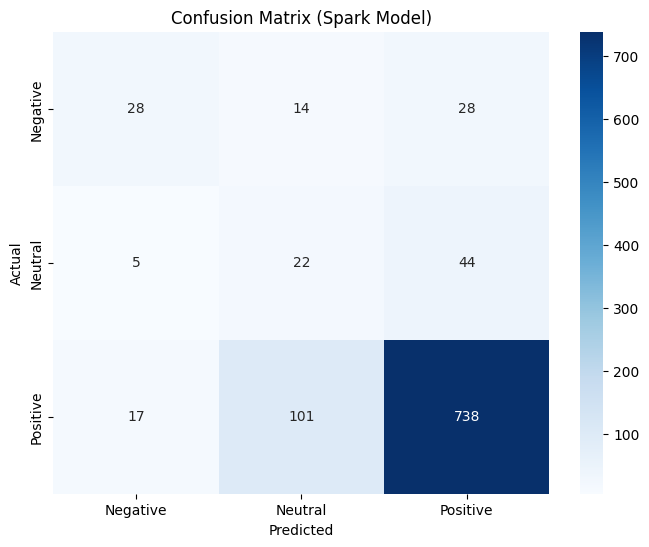

In [13]:
evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

acc = evaluator_acc.evaluate(predictions_gbt)
f1 = evaluator_f1.evaluate(predictions_gbt)
prec = evaluator_precision.evaluate(predictions_gbt)
rec = evaluator_recall.evaluate(predictions_gbt)

print("-" * 30)
print(f"Accuracy  : {acc:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print("-" * 30)

y_true = predictions.select("label").toPandas()
y_pred = predictions.select("prediction").toPandas()

cm = confusion_matrix(y_true, y_pred)
labels = ['Negative', 'Neutral', 'Positive']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Spark Model)')
plt.show()